In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from metrics import custom_score, ultimate_score

In [2]:
df = pd.read_csv("data/x_train.txt", sep=" ", header=None)
print(df.head())
print(df.shape)

y = pd.read_csv("data/y_train.txt", sep=" ", header=None)
y = np.array(y).ravel()
print(y[:5])
print(y.shape)

df_test = pd.read_csv("data/x_test.txt", sep=" ", header=None)
print(df_test.head())
print(df_test.shape)

         0          1          2          3          4          5    \
0  20.454647  16.739345  39.811892  24.955468  27.088535  17.116793   
1  16.175225  10.483281  27.471017  18.509824  19.045353  15.039082   
2  10.577212  10.795115  24.621388  17.264747  14.221610   8.754692   
3  26.299206  13.471215  51.725934  40.786947  26.052414  33.200702   
4  23.193955  20.037969  37.780290  28.983748  25.510508  15.970348   

         6          7          8          9    ...        490        491  \
0  25.166957  23.364508  17.223886  18.339175  ...  13.235314   5.160379   
1  21.354915  15.790575  13.912508  13.772518  ...  13.355832   2.609716   
2  18.399259  11.358798  15.432650  14.842153  ...  15.179359  10.200144   
3  51.014330  27.685009  33.107991  25.359457  ...   7.693654   6.359187   
4  27.930757  20.707354  25.341768  27.118987  ...   7.068407   7.180632   

         492        493        494        495        496        497  \
0  29.194846  17.298314   6.414267   7.780568

In [1]:
# Possible feature selection methods:
# based on feature importance
# Recursive Feature Elimination
# forward/backward selection (with ultimate score function)
# filters: SelectKBest - mutual information/correlation, chi2

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
df_test.shape[0]
# we want to identify 1000 ones in 5000 dataset (there should be about 2500 ones there - balanced)

k_test = int(1000 / df_test.shape[0] * X_test.shape[0]) # equivalently, we want look for 300 ones in X_test
k_test

300

## Logistic regression

In [7]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

prob = lr.predict_proba(X_test)
pred = lr.predict(X_test)

print(f"accuracy: {accuracy_score(y_test, pred)}")
print(f"score: {custom_score(y_test, prob, k_test)}")
print(f"ultimate score: {ultimate_score(y_test, prob, k_test, X_test.shape[1])}")

accuracy: 0.6
score: 0.6833333333333333
ultimate score: -93170.0


## Random forest

In [8]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

prob = rf.predict_proba(X_test)
pred = rf.predict(X_test)

print(f"accuracy: {accuracy_score(y_test, pred)}")
print(f"score: {custom_score(y_test, prob, k_test)}")
print(f"ultimate score: {ultimate_score(y_test, prob, k_test, X_test.shape[1])}")

accuracy: 0.696
score: 0.7466666666666667
ultimate score: -92540.0


In [28]:
importances = rf.feature_importances_

feature_names = np.arange(X_train.shape[1])

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
print(feature_importance_df)

features = np.array(feature_importance_df.feature)

     feature  importance
0          0    0.084783
1          1    0.066899
2          6    0.059203
3          2    0.055466
4          3    0.050226
..       ...         ...
495      416    0.000000
496      364    0.000000
497      273    0.000000
498      496    0.000000
499      202    0.000000

[500 rows x 2 columns]


In [29]:
scores = []
ultimate_scores = []
n_features = np.arange(1, len(features) + 1)

for i in n_features:
    selected_features = features[:i]
    X_train_filtered = X_train[:, selected_features]
    X_test_filtered = X_test[:, selected_features]
    
    rf = RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=-1, random_state=42)
    rf.fit(X_train_filtered, y_train)
    prob = rf.predict_proba(X_test_filtered)
    
    score = custom_score(y_test, prob, k_test)
    scores.append(score)
    ult_score = ultimate_score(y_test, prob, k_test, i)
    ultimate_scores.append(ult_score)

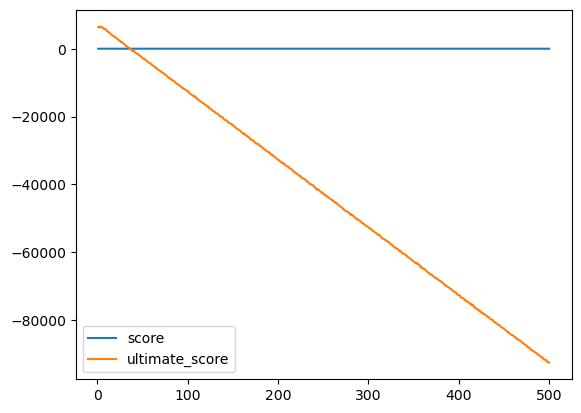

In [30]:
plt.plot(n_features, scores)
plt.plot(n_features, ultimate_scores)
plt.legend(['score', 'ultimate_score'])
plt.show()

In [31]:
print(f"max score: {np.max(ultimate_scores)}")
print(f"no. of features: {n_features[np.argmax(ultimate_scores)]}")

max score: 6560.0
no. of features: 3


## XGBoost

In [56]:
xgb = XGBClassifier(n_estimators=100, max_depth=5, n_jobs=-1, random_state=42)
xgb.fit(X_train, y_train)

prob = xgb.predict_proba(X_test)
pred = xgb.predict(X_test)

print(f"accuracy: {accuracy_score(y_test, pred)}")
print(f"score: {custom_score(y_test, prob, k_test)}")

accuracy: 0.6813333333333333
objective function: 0.7066666666666667


In [16]:
importances = xgb.feature_importances_

feature_names = np.arange(X_train.shape[1])

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
print(feature_importance_df)

features = np.array(feature_importance_df.feature)

     feature  importance
2          2    0.022566
376      376    0.009113
4          4    0.006247
288      288    0.005461
202      202    0.005405
..       ...         ...
316      316    0.000000
305      305    0.000000
299      299    0.000000
297      297    0.000000
133      133    0.000000

[500 rows x 2 columns]


In [18]:
results = []
n_features = np.arange(1, len(features) + 1)

for i in n_features:
    selected_features = features[:i]
    X_train_filtered = X_train[:, selected_features]
    X_test_filtered = X_test[:, selected_features]
    
    xgb = XGBClassifier(n_estimators=100, max_depth=5, n_jobs=-1, random_state=42)
    xgb.fit(X_train_filtered, y_train)
    pred = xgb.predict(X_test_filtered)
    acc = accuracy_score(y_test, pred)

    results.append(acc)

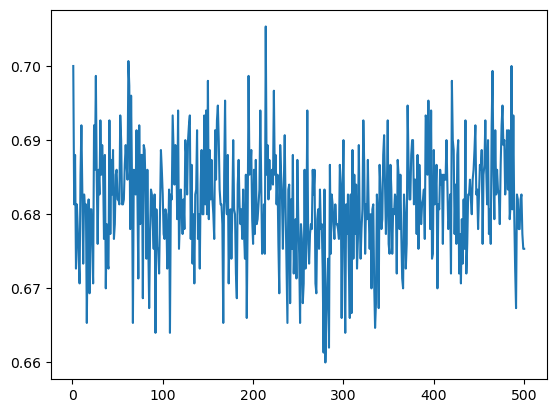

In [19]:
plt.plot(n_features, results)
plt.show()

In [20]:
print(np.max(results))
print(np.argmax(results))

0.7053333333333334
213


In [21]:
pred = xgb.predict(df_test.iloc[:, selected_features])
# number of ones
# pred(len(np.where(pred == 1)))
len(np.where(pred == 1)[0])

4499

## SVM

In [58]:
svm = SVC(kernel='linear', random_state=42, probability=True)
svm.fit(X_train, y_train)

prob = svm.predict_proba(X_test)
pred = svm.predict(X_test)

print(f"accuracy: {accuracy_score(y_test, pred)}")
print(f"score: {custom_score(y_test, prob, k_test)}")

accuracy: 0.6086666666666667
objective function: 0.69
